In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [ ]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,         
                                          shuffle=False)

In [ ]:
test_loader

In [ ]:
train_loader2 = []
for x, y in train_loader:
    train_loader2.append((x, y))

In [ ]:
test_loader2 = []
for x, y in test_loader:
    test_loader2.append((x, y))

In [ ]:
it = 0
ttt = time.time()
for _, (x_batch, y_batch) in zip(range(len(train_loader2)), train_loader2):
    it += 1
for batch_num, (x_batch, y_batch) in enumerate(test_loader2):  
    it += 1
print(time.time() - ttt)

0.0002713203430175781


In [ ]:
it

275

In [ ]:
from tqdm import trange
from copy import deepcopy
        
def train_epoch(model, optimizer, device, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(range(len(train_loader2)), train_loader2):
        data = x_batch
        target = y_batch
        optimizer.zero_grad()
        output = model(data.to(device))   
        
        
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()

        pred = torch.max(output.cpu(), 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.cpu().item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, device):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader2):  
        data = x_batch
        target = y_batch
        output = model(data.to(device))   
        
        
        loss = F.nll_loss(output, target.to(device))

        pred = torch.max(output.cpu(), 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.cpu().item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs, device):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    models = []
    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, device, batchsize=batchsize)
        models.append(deepcopy(model.cpu()))
        model.to(device)
        val_loss, val_acc = test(model, device)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        #clear_output()
        #plot_history(train_log, val_log)    
        #plot_history(train_acc_log, val_acc_log, title='accuracy') 
    i = torch.argmax(torch.tensor(val_acc_log)[:, 1])
    print("Final error: {:.2%}".format(1 - val_acc_log[i][1]))
    return models[i], i, 1 - val_acc_log[i][1]

In [ ]:
class LinNet(nn.Module):
    def __init__(self, masks=[torch.ones(300, 784), torch.ones(100, 300), torch.ones(10, 100)]):
        super().__init__()

        torch.random.manual_seed(42)
        self.classifier = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        self.masks = masks

    def forward(self, x):
        out = x.reshape(-1, 784)
        for i in range(3):
            out = F.linear(out, (self.classifier[2 * i].weight * self.masks[i].to(self.classifier[2 * i].weight.device)), self.classifier[2 * i].bias)
            if (i != 2):
                out = self.classifier[2 * i + 1](out)
        #out = self.classifier(out)
        return F.log_softmax(out, dim=-1) #скопировал из дз3

In [ ]:
from copy import deepcopy
def prune_iter(model, p_left, masks):
    torch_zeros = []
    for i in range(3):
        with torch.no_grad():
            weight_cur = torch.flatten(torch.abs(model.classifier[2 * i].weight.data * masks[i]))
            torch_zeros += (weight_cur.numpy().tolist())
    threshold = sorted(torch_zeros)[int((1 - p_left) * len(torch_zeros))]
    masksnew = list([deepcopy(i) for i in masks])
    for i in range(3):
        with torch.no_grad():
            weight_cur = (torch.abs(model.classifier[2 * i].weight.data * masks[i]))
            masksnew[i] = (weight_cur > threshold)
    return masksnew

In [ ]:
device

device(type='cuda')

In [ ]:
masks = [torch.ones(300, 784), torch.ones(100, 300), torch.ones(10, 100)]
i_s = []
import time
tt = time.time()
masks_arch = []
errrates = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i in range(60):
    model = LinNet(masks).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    model_trained, iterat, errrate = train(model, opt, 100, device)
    errrates.append(errrate)
    i_s.append(iterat.item())
    masks_arch.append(masks)
    masks = prune_iter(model_trained, 0.9**(i + 1), masks)
    print(0.9**(i), iterat.item(), errrate, time.time() - tt, flush=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Final error: 1.68%
1.0 61 0.016796886920928955 57.54004192352295
Final error: 1.75%
0.9 84 0.01748049259185791 108.64044284820557
Final error: 1.75%
0.81 31 0.01748049259185791 160.62773966789246
Final error: 1.77%
0.7290000000000001 63 0.01767575740814209 212.41974520683289
Final error: 1.74%
0.6561 99 0.017382800579071045 263.9081242084503
Final error: 1.71%
0.5904900000000001 30 0.01708984375 315.3728563785553
Final error: 1.79%
0.531441 22 0.017871081829071045 367.30757904052734
Final error: 1.73%
0.4782969000000001 22 0.017285168170928955 419.46232652664185
Final error: 1.75%
0.4304672100000001 69 0.01748049259185791 471.03142523765564
Final error: 1.70%
0.3874204890000001 64 0.01699221134185791 522.5868582725525
Final error: 1.68%
0.3486784401000001 20 0.016796886920928955 574.0832266807556
Final error: 1.71%
0.31381059609000006 17 0.01708984375 625.7802832126617
Final error: 1.71%
0.2824295364810001 53 0.01708984375 677.508348941803
Final error: 1.71%
0.2541865828329001 18 0.017

In [ ]:
input_size = 784
num_classes = 10
batch_size = 256

train_datasetf = dsets.FashionMNIST(root='./FashionMNIST/', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_datasetf = dsets.FashionMNIST(root='./FashionMNIST/', 
                           train=False, 
                           transform=transforms.ToTensor())


train_loader_f2 = torch.utils.data.DataLoader(dataset=train_datasetf,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader_f2 = torch.utils.data.DataLoader(dataset=test_datasetf, 
                                          batch_size=batch_size,         
                                          shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [ ]:
train_loaderf = []
test_loaderf = []
for (x, y) in train_loader_f2:
    train_loaderf.append((x, y))
for (x, y) in test_loader_f2:
    test_loaderf.append((x, y))


In [ ]:
from tqdm import trange
from copy import deepcopy
        
def train_epoch2(model, optimizer, device, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for _, (x_batch, y_batch) in zip(range(len(train_loaderf)), train_loaderf):
        data = x_batch
        target = y_batch
        optimizer.zero_grad()
        output = model(data.to(device))   
        
        
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()

        pred = torch.max(output.cpu(), 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.cpu().item()
        loss_log.append(loss)
    return loss_log, acc_log

def test2(model, device):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loaderf):  
        data = x_batch
        target = y_batch
        output = model(data.to(device))   
        
        
        loss = F.nll_loss(output, target.to(device))

        pred = torch.max(output.cpu(), 1)[1]
        acc = torch.eq(pred, y_batch).float().mean()
        acc_log.append(acc)

        loss = loss.cpu().item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history2(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train2(model, opt, n_epochs, device):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    models = []
    batchsize = 32

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch2(model, opt, device, batchsize=batchsize)
        models.append(deepcopy(model.cpu()))
        model.to(device)
        val_loss, val_acc = test2(model, device)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        #clear_output()
        #plot_history(train_log, val_log)    
        #plot_history(train_acc_log, val_acc_log, title='accuracy') 
    i = torch.argmax(torch.tensor(val_acc_log)[:, 1])
    print("Final error: {:.2%}".format(1 - val_acc_log[i][1]))
    return models[i], i, 1 - val_acc_log[i][1]

In [ ]:
i_sf = []
import time
tt = time.time()
errratesf = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i in range(60):
    model = LinNet(masks_arch[i]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    model_trained, iterat, errrate = train2(model, opt, 100, device)
    errratesf.append(errrate)
    i_sf.append(iterat.item())
    print(0.9**(i), iterat.item(), errrate, time.time() - tt, flush=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Final error: 11.04%
1.0 56 0.11044919490814209 58.358412981033325
Final error: 10.86%
0.9 30 0.10859376192092896 109.9503402709961
Final error: 10.86%
0.81 65 0.10859376192092896 161.4092140197754
Final error: 10.84%
0.7290000000000001 71 0.1083984375 212.91086435317993
Final error: 10.36%
0.6561 59 0.10361325740814209 264.45611238479614
Final error: 10.75%
0.5904900000000001 65 0.10751950740814209 316.35742259025574
Final error: 11.12%
0.531441 75 0.11123049259185791 368.07178711891174
Final error: 10.76%
0.4782969000000001 53 0.10761719942092896 419.71117973327637
Final error: 10.95%
0.4304672100000001 69 0.10947263240814209 471.4484634399414
Final error: 10.99%
0.3874204890000001 81 0.10986328125 523.0073430538177
Final error: 10.81%
0.3486784401000001 51 0.10810548067092896 574.8738868236542
Final error: 11.06%
0.31381059609000006 49 0.11064451932907104 626.683253288269
Final error: 11.45%
0.2824295364810001 82 0.11445313692092896 678.3511321544647
Final error: 11.37%
0.25418658283

In [ ]:
masks = [torch.ones(300, 784), torch.ones(100, 300), torch.ones(10, 100)]

i_sff = []
import time
tt = time.time()
errratesff = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i in range(60):
    model = LinNet(masks).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    model_trained, iterat, errrate = train2(model, opt, 100, device)
    errratesff.append(errrate)
    i_sff.append(iterat.item())
    masks = prune_iter(model_trained, 0.9**(i + 1), masks)
    print(0.9**(i), iterat.item(), errrate, time.time() - tt, flush=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Final error: 11.04%
1.0 56 0.11044919490814209 58.00900220870972
Final error: 10.88%
0.9 54 0.10878908634185791 109.85645771026611
Final error: 10.68%
0.81 38 0.10683596134185791 161.53255033493042
Final error: 10.66%
0.7290000000000001 57 0.10664063692092896 212.8877990245819
Final error: 10.89%
0.6561 35 0.10888671875 264.5922956466675
Final error: 10.76%
0.5904900000000001 59 0.10761719942092896 316.16889476776123
Final error: 10.65%
0.531441 40 0.10654294490814209 367.7014741897583
Final error: 10.78%
0.4782969000000001 47 0.10781252384185791 419.2623653411865
Final error: 10.50%
0.4304672100000001 28 0.10498046875 471.0256652832031
Final error: 10.71%
0.3874204890000001 46 0.10712891817092896 522.8253767490387
Final error: 10.78%
0.3486784401000001 43 0.10781252384185791 574.4895691871643
Final error: 10.62%
0.31381059609000006 18 0.10624998807907104 626.0591554641724
Final error: 10.62%
0.2824295364810001 37 0.10624998807907104 677.8511562347412
Final error: 10.43%
0.254186582832

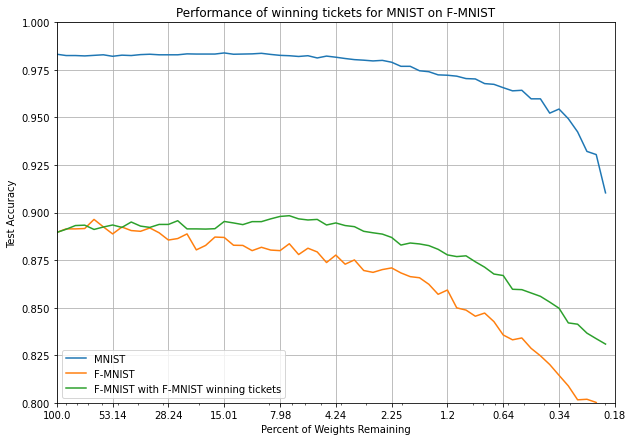

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(0.9**np.arange(60), 1 - np.array(errrates), label='MNIST')
plt.plot(0.9**np.arange(60), 1 - np.array(errratesf), label='F-MNIST')
plt.plot(0.9**np.arange(60), 1 - np.array(errratesff), label='F-MNIST with F-MNIST winning tickets')

plt.xscale('log')
plt.axis([1, 0.9**60, 0.8, 1])
plt.xticks([0.9**(6 * i) for i in range(11)], [str(round(100 * 0.9**(6 * i), 2)) for i in range(11)])
plt.grid()
plt.ylabel('Test Accuracy')
plt.xlabel('Percent of Weights Remaining')
plt.title('Performance of winning tickets for MNIST on F-MNIST')
plt.legend()
plt.show()